In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from src.data import compute_psi, compute_psi_for_features

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load data
df = pd.read_csv('../data/hour.csv')
df['dteday'] = pd.to_datetime(df['dteday'])

# Split by year
train_2011 = df[df['yr'] == 0].copy()
eval_2012 = df[df['yr'] == 1].copy()

print(f"2011 records: {len(train_2011):,}")
print(f"2012 records: {len(eval_2012):,}")

2011 records: 8,645
2012 records: 8,734


## 1. Population Stability Index (PSI) Analysis

PSI measures how much a distribution has shifted from a reference baseline:
- **PSI < 0.1**: No significant shift
- **0.1 ≤ PSI < 0.2**: Moderate shift, investigation recommended
- **PSI ≥ 0.2**: Significant shift, action required

In [3]:
# Compute PSI for numeric features
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']

psi_results = compute_psi_for_features(train_2011, eval_2012, numeric_features)

print("PSI Analysis: 2011 (reference) vs 2012 (current)")
print("=" * 50)
for feature, psi in sorted(psi_results.items(), key=lambda x: x[1], reverse=True):
    if psi < 0.1:
        status = "✓ No drift"
    elif psi < 0.2:
        status = "⚠ Moderate drift"
    else:
        status = "⚡ Significant drift"
    print(f"{feature:12s}: PSI = {psi:.4f}  {status}")

PSI Analysis: 2011 (reference) vs 2012 (current)
hum         : PSI = 0.0483  ✓ No drift
temp        : PSI = 0.0355  ✓ No drift
atemp       : PSI = 0.0329  ✓ No drift
windspeed   : PSI = 0.0036  ✓ No drift


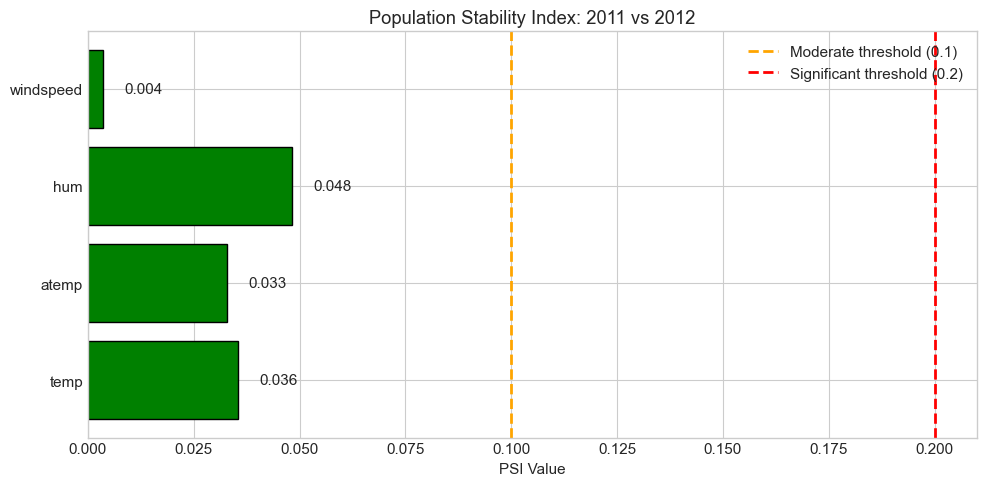

In [4]:
# Visualize PSI values
fig, ax = plt.subplots(figsize=(10, 5))

features = list(psi_results.keys())
psi_values = list(psi_results.values())

colors = ['green' if p < 0.1 else 'orange' if p < 0.2 else 'red' for p in psi_values]

bars = ax.barh(features, psi_values, color=colors, edgecolor='black')
ax.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='Moderate threshold (0.1)')
ax.axvline(x=0.2, color='red', linestyle='--', linewidth=2, label='Significant threshold (0.2)')

ax.set_xlabel('PSI Value')
ax.set_title('Population Stability Index: 2011 vs 2012')
ax.legend()

for bar, psi in zip(bars, psi_values):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{psi:.3f}', va='center')

plt.tight_layout()
plt.show()

## 2. Kolmogorov-Smirnov Test

The KS test provides a statistical significance measure for distribution differences.

In [5]:
# Perform KS tests
print("Kolmogorov-Smirnov Test Results")
print("=" * 60)
print(f"{'Feature':<12} {'KS Statistic':<15} {'p-value':<15} {'Significant?'}")
print("-" * 60)

ks_results = {}
for feature in numeric_features:
    ks_stat, p_value = stats.ks_2samp(train_2011[feature], eval_2012[feature])
    ks_results[feature] = {'statistic': ks_stat, 'p_value': p_value}
    
    significant = "Yes" if p_value < 0.05 else "No"
    print(f"{feature:<12} {ks_stat:<15.4f} {p_value:<15.4e} {significant}")

print("\nNote: p-value < 0.05 indicates statistically significant difference")

Kolmogorov-Smirnov Test Results
Feature      KS Statistic    p-value         Significant?
------------------------------------------------------------
temp         0.0546          1.0323e-11      Yes
atemp        0.0462          1.6695e-08      Yes
hum          0.0651          1.9098e-16      Yes
windspeed    0.0192          7.8685e-02      No

Note: p-value < 0.05 indicates statistically significant difference


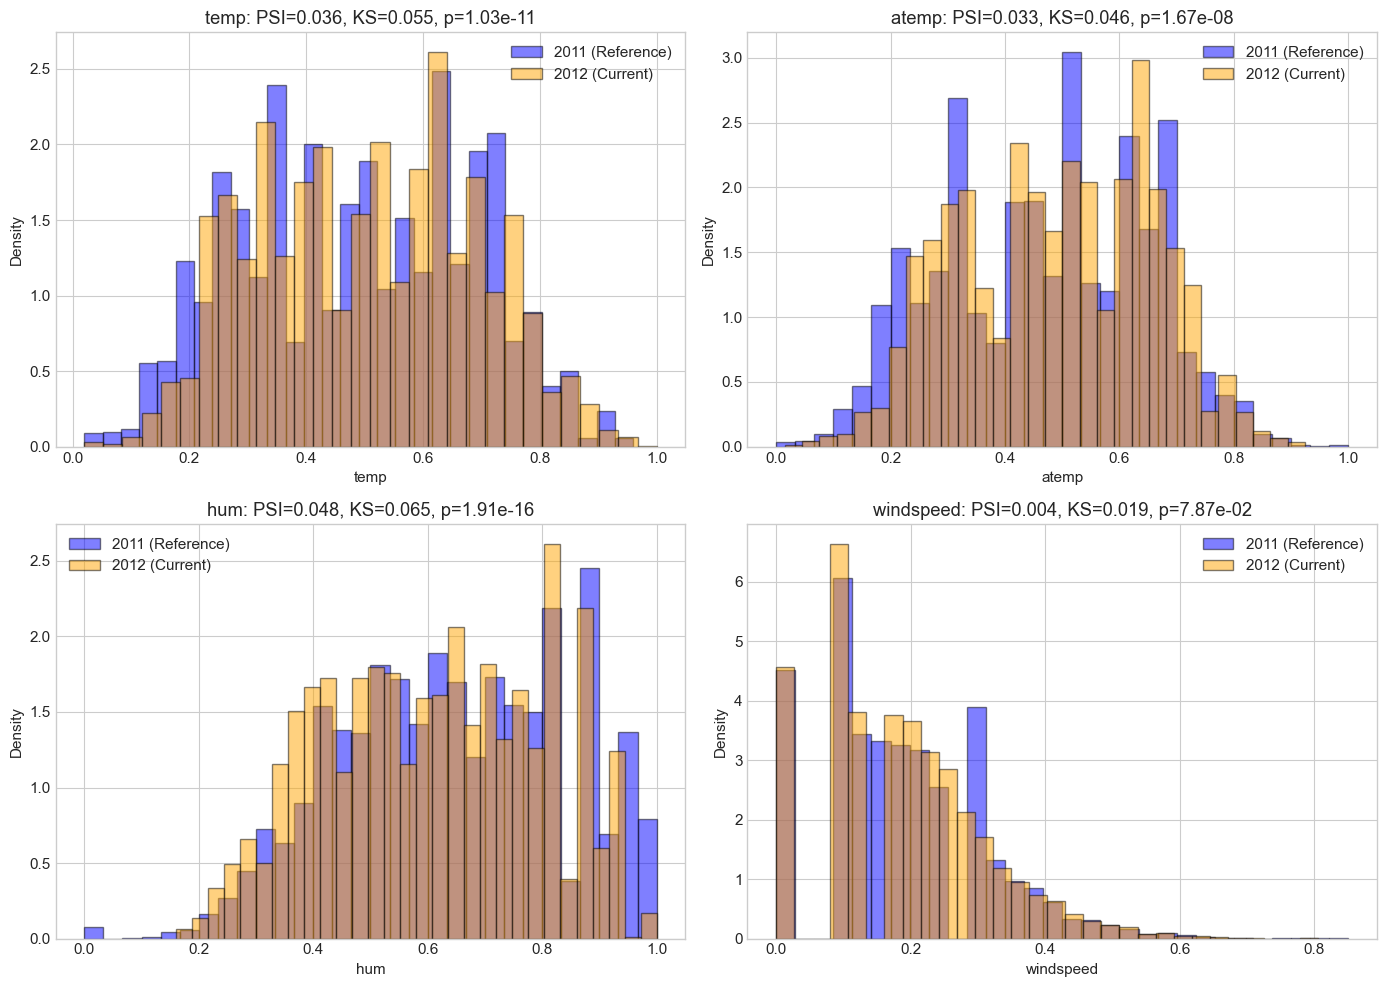

In [6]:
# Visualize distribution comparisons
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    ax = axes[i]
    
    # Histogram comparison
    ax.hist(train_2011[feature], bins=30, alpha=0.5, density=True, 
            label='2011 (Reference)', color='blue', edgecolor='black')
    ax.hist(eval_2012[feature], bins=30, alpha=0.5, density=True, 
            label='2012 (Current)', color='orange', edgecolor='black')
    
    # Add PSI and KS stats
    psi = psi_results[feature]
    ks = ks_results[feature]['statistic']
    p = ks_results[feature]['p_value']
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature}: PSI={psi:.3f}, KS={ks:.3f}, p={p:.2e}')
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Model Performance Analysis

Train the same baseline model and analyze error patterns.

In [7]:
# Train baseline model
feature_cols = [
    'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
]

X_train = train_2011[feature_cols]
y_train = train_2011['cnt']
X_test = eval_2012[feature_cols]
y_test = eval_2012['cnt']

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Baseline RMSE on 2012 data: {baseline_rmse:.2f}")

Baseline RMSE on 2012 data: 125.66


In [8]:
# Add predictions to 2012 data for analysis
eval_2012_analysis = eval_2012.copy()
eval_2012_analysis['predicted'] = y_pred
eval_2012_analysis['error'] = eval_2012_analysis['cnt'] - eval_2012_analysis['predicted']
eval_2012_analysis['abs_error'] = np.abs(eval_2012_analysis['error'])

### 3.1 Error by Season

In [9]:
# RMSE by season
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}

seasonal_rmse = eval_2012_analysis.groupby('season').apply(
    lambda x: np.sqrt(mean_squared_error(x['cnt'], x['predicted'])),
    include_groups=False
)

seasonal_mae = eval_2012_analysis.groupby('season')['abs_error'].mean()
seasonal_bias = eval_2012_analysis.groupby('season')['error'].mean()

print("Model Performance by Season (2012)")
print("=" * 50)
print(f"{'Season':<10} {'RMSE':<10} {'MAE':<10} {'Bias':<10}")
print("-" * 50)
for season in [1, 2, 3, 4]:
    print(f"{season_names[season]:<10} {seasonal_rmse[season]:<10.2f} {seasonal_mae[season]:<10.2f} {seasonal_bias[season]:<+10.2f}")

Model Performance by Season (2012)
Season     RMSE       MAE        Bias      
--------------------------------------------------
Winter     106.13     71.14      +66.55    
Spring     132.99     95.39      +88.76    
Summer     131.17     97.41      +93.89    
Fall       130.25     92.14      +85.90    


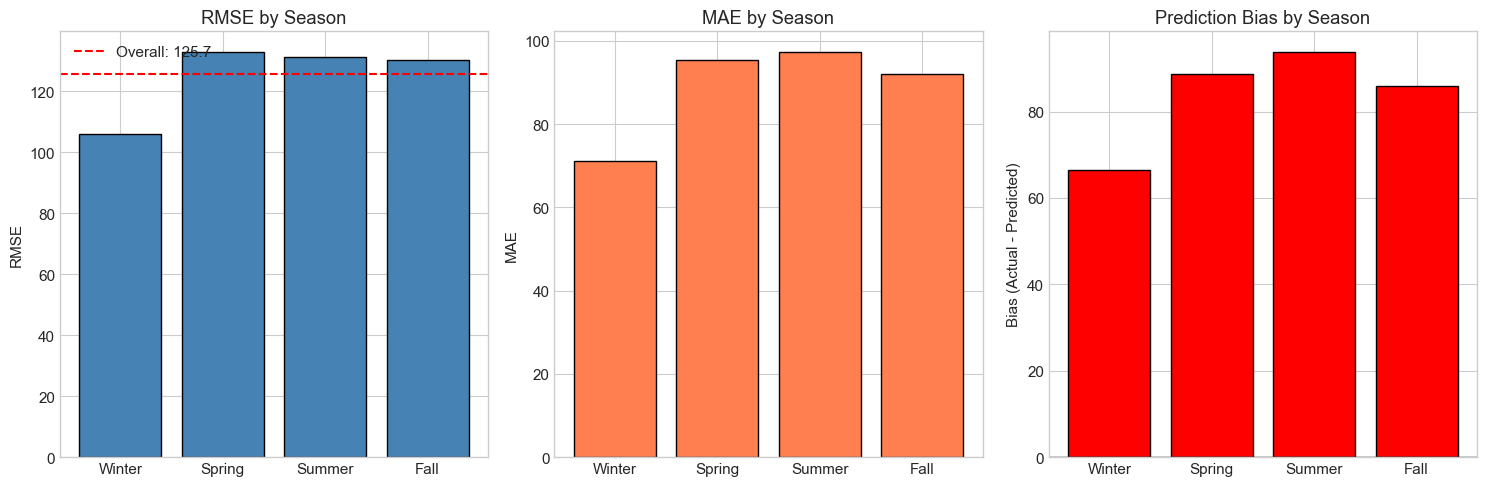

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

seasons = [season_names[i] for i in [1, 2, 3, 4]]

# RMSE by season
axes[0].bar(seasons, seasonal_rmse.values, color='steelblue', edgecolor='black')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Season')
axes[0].axhline(y=baseline_rmse, color='red', linestyle='--', label=f'Overall: {baseline_rmse:.1f}')
axes[0].legend()

# MAE by season
axes[1].bar(seasons, seasonal_mae.values, color='coral', edgecolor='black')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE by Season')

# Bias by season
colors = ['green' if b < 0 else 'red' for b in seasonal_bias.values]
axes[2].bar(seasons, seasonal_bias.values, color=colors, edgecolor='black')
axes[2].set_ylabel('Bias (Actual - Predicted)')
axes[2].set_title('Prediction Bias by Season')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

### 3.2 Error by Month

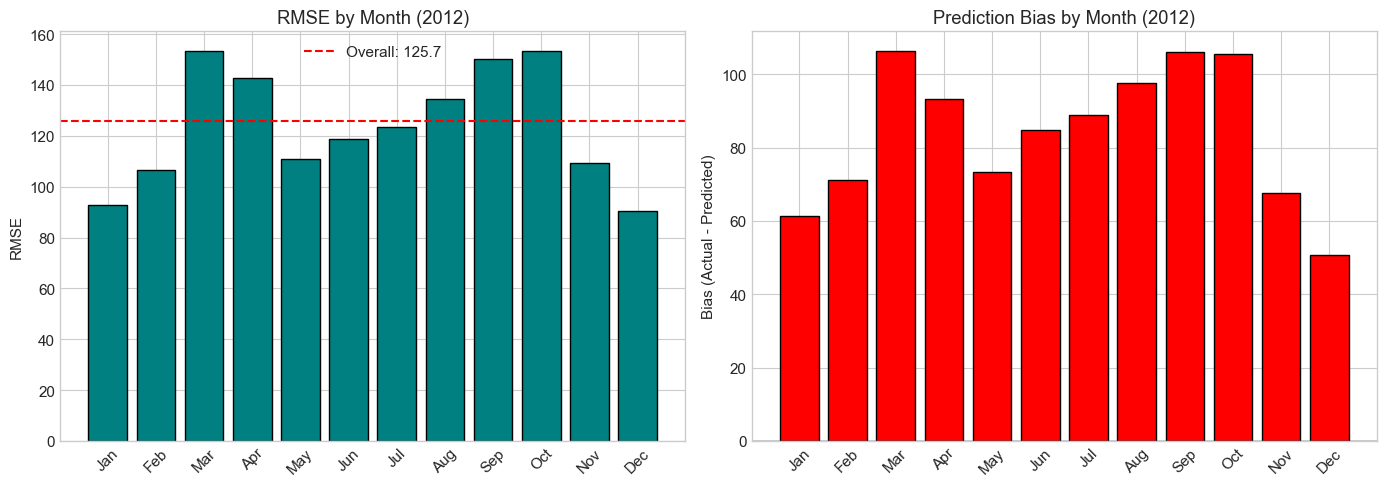

In [11]:
# RMSE by month
monthly_rmse = eval_2012_analysis.groupby('mnth').apply(
    lambda x: np.sqrt(mean_squared_error(x['cnt'], x['predicted'])),
    include_groups=False
)

monthly_bias = eval_2012_analysis.groupby('mnth')['error'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

months = range(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[0].bar(month_names, monthly_rmse.values, color='teal', edgecolor='black')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Month (2012)')
axes[0].axhline(y=baseline_rmse, color='red', linestyle='--', label=f'Overall: {baseline_rmse:.1f}')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

colors = ['green' if b < 0 else 'red' for b in monthly_bias.values]
axes[1].bar(month_names, monthly_bias.values, color=colors, edgecolor='black')
axes[1].set_ylabel('Bias (Actual - Predicted)')
axes[1].set_title('Prediction Bias by Month (2012)')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.3 Error by Hour

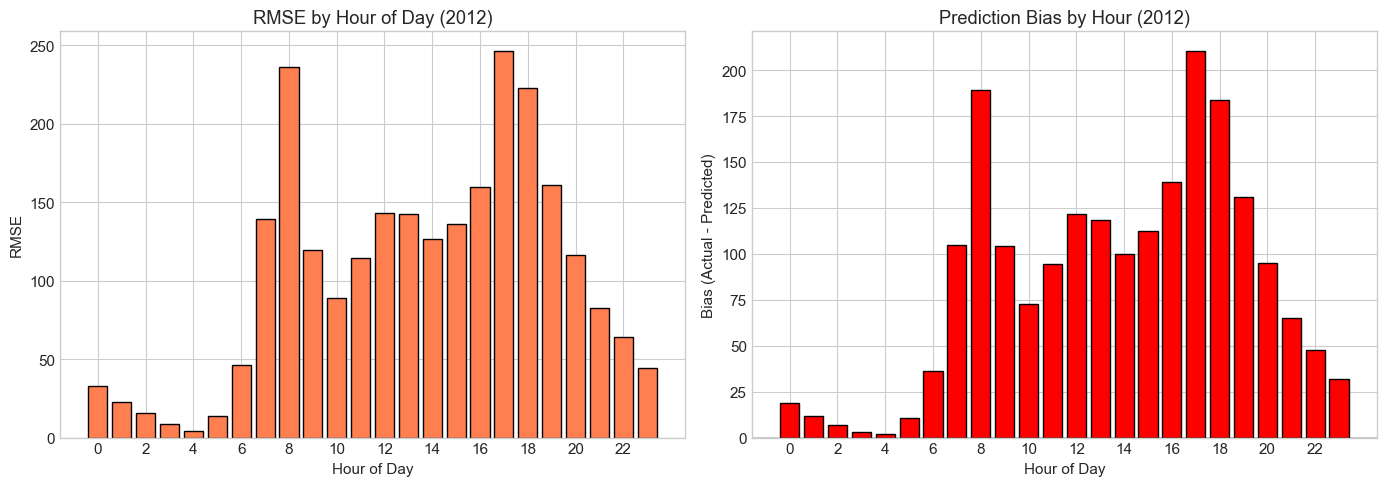

In [12]:
# RMSE and bias by hour
hourly_rmse = eval_2012_analysis.groupby('hr').apply(
    lambda x: np.sqrt(mean_squared_error(x['cnt'], x['predicted'])),
    include_groups=False
)

hourly_bias = eval_2012_analysis.groupby('hr')['error'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(24), hourly_rmse.values, color='coral', edgecolor='black')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Hour of Day (2012)')
axes[0].set_xticks(range(0, 24, 2))

colors = ['green' if b < 0 else 'red' for b in hourly_bias.values]
axes[1].bar(range(24), hourly_bias.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Bias (Actual - Predicted)')
axes[1].set_title('Prediction Bias by Hour (2012)')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

## 4. Summary: Natural Drift Findings

In [13]:
# Summary statistics
print("="*60)
print("NATURAL DRIFT ANALYSIS SUMMARY")
print("="*60)

print("\n1. FEATURE DISTRIBUTION DRIFT (PSI)")
print("-"*40)
any_drift = False
for feature, psi in sorted(psi_results.items(), key=lambda x: x[1], reverse=True):
    if psi >= 0.1:
        any_drift = True
        print(f"   {feature}: PSI = {psi:.4f} (drift detected)")
    else:
        print(f"   {feature}: PSI = {psi:.4f} (no drift)")

print("\n2. TARGET VARIABLE DRIFT")
print("-"*40)
target_2011_mean = train_2011['cnt'].mean()
target_2012_mean = eval_2012['cnt'].mean()
pct_change = ((target_2012_mean / target_2011_mean) - 1) * 100
print(f"   2011 mean rentals: {target_2011_mean:.1f}")
print(f"   2012 mean rentals: {target_2012_mean:.1f}")
print(f"   Change: {pct_change:+.1f}%")
print(f"   ⚡ SIGNIFICANT CONCEPT DRIFT (target distribution shifted)")

print("\n3. MODEL PERFORMANCE")
print("-"*40)
print(f"   Training RMSE (2011): ~20")
print(f"   Test RMSE (2012): {baseline_rmse:.2f}")
print(f"   Degradation: ~{(baseline_rmse/20 - 1)*100:.0f}% worse")

print("\n4. ERROR PATTERN INSIGHTS")
print("-"*40)
worst_season = seasonal_rmse.idxmax()
best_season = seasonal_rmse.idxmin()
print(f"   Worst season: {season_names[worst_season]} (RMSE={seasonal_rmse[worst_season]:.1f})")
print(f"   Best season: {season_names[best_season]} (RMSE={seasonal_rmse[best_season]:.1f})")
print(f"   Model consistently UNDER-predicts (positive bias: {eval_2012_analysis['error'].mean():.1f})")

print("\n" + "="*60)
print("KEY FINDING: Model performance degrades significantly due to")
print("CONCEPT DRIFT (relationship between features and target changed)")
print("rather than DATA DRIFT (feature distributions are stable).")
print("="*60)

NATURAL DRIFT ANALYSIS SUMMARY

1. FEATURE DISTRIBUTION DRIFT (PSI)
----------------------------------------
   hum: PSI = 0.0483 (no drift)
   temp: PSI = 0.0355 (no drift)
   atemp: PSI = 0.0329 (no drift)
   windspeed: PSI = 0.0036 (no drift)

2. TARGET VARIABLE DRIFT
----------------------------------------
   2011 mean rentals: 143.8
   2012 mean rentals: 234.7
   Change: +63.2%
   ⚡ SIGNIFICANT CONCEPT DRIFT (target distribution shifted)

3. MODEL PERFORMANCE
----------------------------------------
   Training RMSE (2011): ~20
   Test RMSE (2012): 125.66
   Degradation: ~528% worse

4. ERROR PATTERN INSIGHTS
----------------------------------------
   Worst season: Spring (RMSE=133.0)
   Best season: Winter (RMSE=106.1)
   Model consistently UNDER-predicts (positive bias: 83.9)

KEY FINDING: Model performance degrades significantly due to
CONCEPT DRIFT (relationship between features and target changed)
rather than DATA DRIFT (feature distributions are stable).
